# SiMFS-Tk Example: Multiple molecules

This example builds upon the single molecule example. With pysimfs you can easily add more than one molecule to your simulation and run them in parallel. To join the results to a single photon trace together, we use ``simfs_mix``.

### Components

- ``simfs_dif``
- ``simfs_buf``
- ``simfs_exi``
- ``simfs_det``
- ``simfs_ph2``
- ``simfs_spl``
- ``simfs_mix``

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'

from pysimfs import *

All simfs components found in /opt/SiMFS-Tk/SiMFS-core/build/src/components/.


### Setup a single molecule

First we create the components for a single molecule like in the single molecule example. We leave out the output parameter for the final ``simfs_spl`` component for now.

In [2]:
dif = Diffusion(
    experiment_time=1,
    radius=2e-6,
    half_height=3e-6,
    diffusion_coefficient=4.35e-10,
    coordinate_output='coords', 
    collision_output=os.devnull
)

In [3]:
buf = CoordinateBuffer(
    input='coords', 
    outputs=['coords_exi', 'coords_det']
)

In [4]:
exi = Excitation(
    input='coords_exi',
    type='XYGaussZExp',
    wavelength=488e-9,
    power=50e-6,
    output='exi'
)

In [5]:
det = Detection(
    input='coords_det',
    type='XYGaussZExp',
    shape={
        'waist_xy': 300e-9,
        'waist_z': 800e-9
    },
    output='det'
)

In [6]:
ph2 = Fluorophore(
    initial_state='S0',
    jablonsky = {
        'emi': {
            'from': 'S1',
            'output': 'emi',
            'rate': 1e+8,
            'to': 'S0'
        },
        'exi': {
            'from': 'S0',
            'rate': {
                'input': 'exi',
                'epsilon': 73000
            },
            'to': 'S1'
        },
        'isc': {
            'from': 'S1',
            'rate': 5e+6,
            'to': 'T1'
        },
        'risc': {
            'from': 'T1',
            'rate': 5e+6,
            'to': 'S0'
        }
    }
)

In [7]:
spl = Splitter(
    efficiency_input='det',
    photon_input='emi',
    rejected_output=os.devnull
)

### Setting up multiple molecules

To track multiple molecules we create a list of names for these molecules:

In [8]:
N = 10
mols = [f'mol_{i}' for i in range(N)]

Now we add the components to the simulation. Looping over the molecule list, we add the basic single molecule structure to the simulation multiple times. Pysimfs mangles the repeating input output names once they are matched to unique pipe names. The final output of each molecule (``simfs_spl``'s ``accepted_output``) is manually set to the loop index, which is the molecules name from the list.

Finally we (after the loop) we add a ``simfs_mix`` component that sorts all the molcule emission streams together. It gets passed the whole molecule name list as input and the final photon filename as output.

In [9]:
with Simulation() as S:
    
    # loop over molecules
    for mol in mols:
        
        S.add(dif)
        S.add(buf)
        S.add(exi)
        S.add(det)
        S.add(ph2)
        
        spl.params['accepted_output'] = mol # set the splitter output to the running molecule
        S.add(spl)
        
    # out of loop
    S.add(
        Mixer(
            inputs=mols, # take the list of all molecule outputs as input
            output='photons.dat'
        )
    )
    log = S.run() # run
    photons = S.get_results()['photons.dat']

Folder ./pysimfs_data exists.
Started simulation with 61 component processes.
Simulation completed after 25.63 seconds.


## Inspecting the result

Let's look at the photon data with a timetrace. We bin the 1 second data in 100µs to see the burst pattern. 

Text(0, 0.5, '# photons / 100µs')

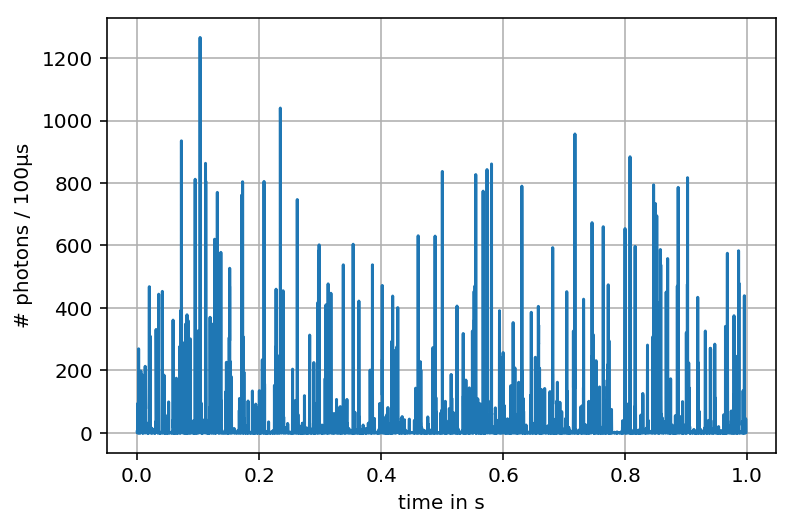

In [10]:
hist, bins = np.histogram(photons, 10000)
plt.plot(bins[:-1], hist)
plt.grid()
plt.xlabel('time in s')
plt.ylabel('# photons / 100µs')

### Correlation

We can look further into the data with a quick correlation. We are going to use [``pycorrelate``](https://pypi.org/project/pycorrelate/) to do so:

In [11]:
from pycorrelate import pcorrelate

In [12]:
tau = np.logspace(-10, -2, 128)
cor = pcorrelate(photons, photons, tau, normalize=True)

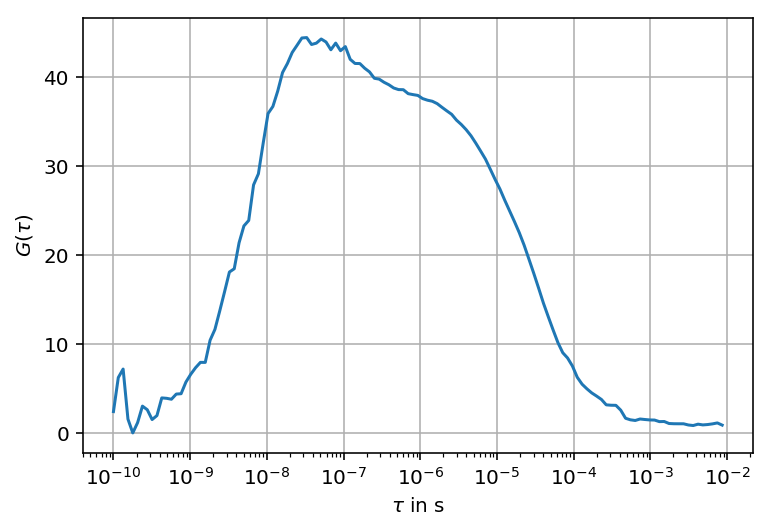

In [13]:
plt.semilogx(tau[:-1], cor)
plt.grid()
_ = plt.xlabel(r'$\tau$ in s')
_ = plt.ylabel(r'$G(\tau)$')

You can see the whole range of fluctuations from antibunching and triplet dynamics up to the diffusion time. Play around with the jablonsky diagram, focus paramters or excitation power to see the changes in different regions of the curve.